# LOO-CV tutorial

In this notebook we will demonstrate how to carry out leave-one-out cross-validation (LOO-CV) using the Pareto-smoothed importance sampling (PSIS) approximation. We will use the example retrieval on a synthetic dataset from Welbanks et al. 2023. We will use the arviz package to do so. We begin by importing the relevant packages:

If you find this tutorial helpful, please consider citing the following papers:
1) Welbanks et al. 2023, On the Application of Bayesian Leave-one-out Cross-validation to Exoplanet Atmospheric Analysis. https://ui.adsabs.harvard.edu/abs/2023AJ....165..112W/abstract

2) McGill et al. 2023, First semi-empirical test of the white dwarf mass-radius relationship using a single white dwarf via astrometric microlensing. https://ui.adsabs.harvard.edu/abs/2023MNRAS.520..259M/abstract

3) Nixon et al. 2024, Methods for Incorporating Model Uncertainty into Exoplanet Atmospheric Analysis. https://ui.adsabs.harvard.edu/abs/2024ApJ...966..156N/abstract

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import arviz as az               #main package required for LOO-CV
from spectres import spectres    #used for plotting only

The main object that we require for LOO-CV is the pointwise log likelihood for a set of equally-weighted posterior samples. This can be generated after a retrieval has been completed by iterating through your equally weighted posteriors and calculating the likelihood function (without summing over wavelengths) for each sample. Alternatively, you can generate binned model realisations for each sample and calculate the likelihood afterwards.

In [3]:
#If you have generated binned model realisations rather than likelihood evaluations, uncomment the lines below
#and load your samples file, then calculate the likelihood function (Gaussian example shown here)

#spectrum = np.loadtxt('full_model_data.txt')
#transit_depth = samples[:,2]
#error = samples[:,3]
#samples_full = np.loadtxt('your_samples.txt')
#loglike_full = -0.5*(((samples_full-transit_depth)/error)**2)-0.5*(np.log(2.0*np.pi*error*error))

#For this example we have saved the pointwise likelihood function, so we load it directly
loglike_full = np.loadtxt('input_files/full_model_loglike.txt')

In order to use the arviz loo function, we need to format our data appropriately. We create an Inference Data object containing the log likelihoods, and a placeholder for the posteriors (this is not needed in the LOO-CV calculation).

In [4]:
#Add an extra dimension to likelihood array so that it is read correctly by arviz
loglike_converted = np.expand_dims(loglike_full,0)

#Create an Inference Data object without likelihoods, and add a placeholder posterior group
loglike_data = az.convert_to_inference_data(loglike_converted,group='log_likelihood')
loglike_data.add_groups(posterior = {"placeholder": np.ones_like(loglike_converted)})

Now we can carry out LOO-CV. We can also check a summary of the calculation to ensure that the Pareto k diagnostics are ok. If the Pareto k value exceeds 0.7 for any data point, it is recommended to re-run your retrieval without that data point rather than relying on the PSIS approximation to calculate the ELPD.

In [5]:
loo = az.loo(loglike_data, var_name = 'x', pointwise = True)
loo

Computed from 12635 posterior samples and 46 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   377.73     4.12
p_loo        3.45        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       46  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Here we find that the Pareto k does not exceed 0.7, so we don't need to worry about running additional retrievals. The ELPD array can be displayed as follows:

In [6]:
loo.loo_i

<xarray.DataArray 'loo_i' (x_dim_0: 46)>
array([8.01260182, 7.43233443, 8.01482515, 8.20378969, 7.06768214,
       8.2099312 , 8.21401725, 8.00484575, 6.8490961 , 8.17591254,
       8.05543145, 8.14358481, 8.06969333, 8.19581124, 7.74666294,
       7.61102783, 7.53870662, 8.0959249 , 8.0559401 , 7.5611265 ,
       8.84935867, 8.86913065, 8.44679183, 7.87344661, 8.92832316,
       8.52217697, 8.41724419, 6.68974244, 8.8298262 , 8.59340074,
       8.94537999, 8.91578932, 8.40836003, 8.92386201, 8.24918784,
       6.8976654 , 8.93610937, 8.95055946, 7.72729349, 7.73344638,
       8.83214178, 8.87146267, 8.84806265, 8.89581548, 8.48820896,
       8.8290029 ])
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45

Now we will plot our retrieved spectrum along with our ELPD scores, reproducing Figure 1 from Welbanks et al. 2023. Note that points with a higher ELPD score are better predicted by the model when left out.

Text(0, 0.5, '$elpd_{{\\it{i}}, Reference}$')

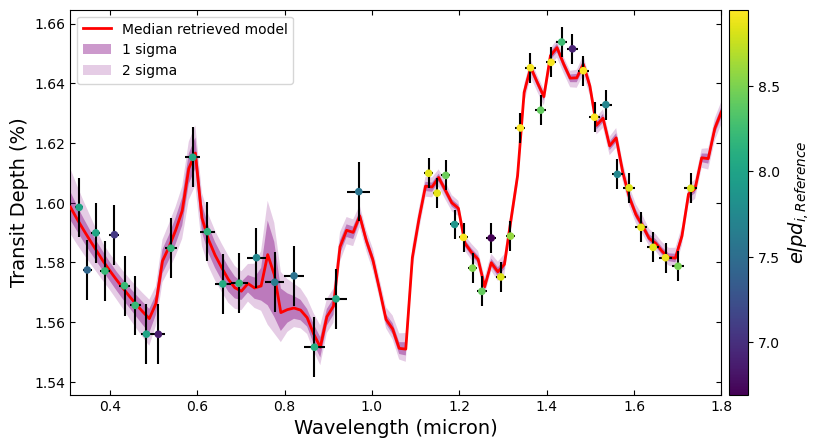

In [7]:
#Load the observed spectrum
spectrum = np.loadtxt('input_files/full_model_data.txt')

#Create figure and axis
fig = plt.figure(figsize = (10,5))
ax = plt.gca()

#Plot data points, colour coded by ELPD score
loo_plot = ax.scatter(spectrum[:,0], spectrum[:,2]*100, s = 20, c = loo.loo_i, zorder = 10)

#Plot errorbars for the data
ax.errorbar(spectrum[:,0], spectrum[:,2]*100, xerr = spectrum[:,1],yerr = spectrum[:,3]*100,
            zorder = 5,color = 'k',ls = 'None')

#Load median retrieved model along with 1 and 2 sigma regions
median = np.loadtxt('input_files/full_model_TD_median_result.txt', ndmin=2)
median_lam = median[:,0]
median_depth = median[:,1]
high1 = np.loadtxt('input_files/full_model_TD_high1sigma.txt', ndmin=2)
high1_depth = high1[:,1]
high2 = np.loadtxt('input_files/full_model_TD_high2sigma.txt', ndmin=2)
high2_depth = high2[:,1]
low1 = np.loadtxt('input_files/full_model_TD_low1sigma.txt', ndmin=2)
low1_depth = low1[:,1]
low2 = np.loadtxt('input_files/full_model_TD_low2sigma.txt', ndmin=2)
low2_depth = low2[:,1]

#Resample to a coarse wavelength grid for better visualisation
new_lam = np.linspace(0.31,1.8,100)

#Plot resampled median model, 1 and 2 sigma regions
ax.plot(new_lam, spectres(new_lam, median_lam, median_depth)*100, lw = 2, color = 'red', 
        zorder = 3, alpha = 1.0, label = 'Median retrieved model')
ax.fill_between(new_lam, spectres(new_lam, median_lam, low1_depth)*100, 
                spectres(new_lam, median_lam, high1_depth)*100, facecolor = 'purple', 
                alpha = 0.4, linewidth = 0.0, zorder = 2, label = '1 sigma')
ax.fill_between(new_lam, spectres(new_lam, median_lam, low2_depth)*100, 
                spectres(new_lam, median_lam, high2_depth)*100,  facecolor = 'purple', 
                alpha = 0.2, linewidth = 0.0, zorder = 1, label = '2 sigma')

#Create legend and format figure
ax.legend()
ax.set_xlim(0.31,1.8)
ax.set_xlabel('Wavelength (micron)', fontsize = 14)
ax.set_ylabel('Transit Depth (%)', fontsize = 14)
ax.tick_params(axis = 'both', which = 'major', direction = 'in', top = True, right = True)

#Create a colour bar for the ELPD scores
cbar = plt.colorbar(loo_plot, ax = ax, pad = 0.01)
cbar.ax.set_ylabel(r'$elpd_{{\it{i}}, Reference}$', fontsize = 14)

Next, we will compare the ELPD between two different models, to assess their performance at the per-data-point level. We will compare the retrieval used above with another retrieval that does not include water absorption.

In [8]:
#Load the pointwise likelihood function
loglike_xH2O = np.loadtxt('input_files/xH2O_loglike.txt')

#Add an extra dimension to likelihood array so that it is read correctly by arviz
loglike_converted_xH2O = np.expand_dims(loglike_xH2O, 0)

#Create an Inference Data object with out likelihoods, and add a placeholder posterior group
loglike_data_xH2O = az.convert_to_inference_data(loglike_converted_xH2O, group = 'log_likelihood')
loglike_data_xH2O.add_groups(posterior = {"placeholder": np.ones_like(loglike_converted_xH2O)})

loo_xH2O = az.loo(loglike_data_xH2O, var_name = 'x', pointwise = True)
loo_xH2O.loo_i

<xarray.DataArray 'loo_i' (x_dim_0: 46)>
array([  3.98127804,   8.06183116,   6.61093626,   8.17851308,
         7.05239782,   8.20909664,   7.66392094,   5.86972343,
         5.35254769,   8.23400248,   4.92715644,   8.19909725,
         7.35296038,   7.3320196 ,   8.08417336,   6.89613973,
         7.11978088,  -0.15974461,   4.84516208,   7.91102096,
         6.9866673 ,   8.83394907,   7.68249823,   7.18354873,
         4.79304663,  -4.03869461, -14.13589106,   3.62940538,
        -9.26104559,   3.28828038,   1.43212917, -21.92822325,
        -2.80251551, -22.98897777, -33.93427278, -28.76018691,
       -16.06411416,   1.83675631,  -1.2491158 ,   8.8841802 ,
         7.91555605,  -0.25763342,  -7.92929244, -13.20527669,
       -18.34438059,   6.69428983])
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45

We can already see that at certain wavelengths, the performance of the model without water is much worse than the full model. We can compare the performance between models by calculating the difference in ELPD between the models. Here we plot the spectrum along with the difference in ELPD for each data point. A high (positive) value means that the model with water is more strongly preferred by that data point, while a low (negative) value means that the model without water is more strongly preferred.

This plot is a reproduction of the top left panel of Figure 2 from Welbanks et al. 2023.

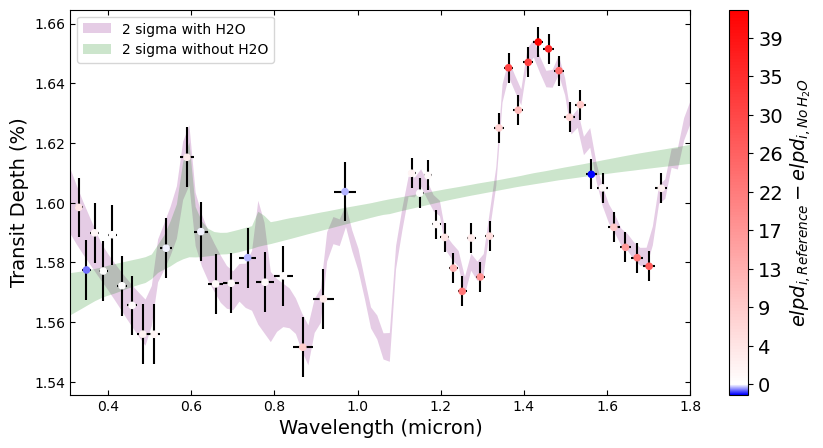

In [9]:
#Create figure and axis
fig2 = plt.figure(figsize = (10,5))
ax2 = plt.gca()

#calculating the difference in scores
loo_score=loo.loo_i-loo_xH2O.loo_i


#Adjust colour map properties to be centred at 0
bounds = np.arange(np.min(loo_score),np.max(loo_score),0.001)
idx = np.searchsorted(bounds,0)
bounds = np.insert(bounds,idx,0)
offset = mcolors.TwoSlopeNorm(vmin = np.min(loo_score), vcenter = 0.0, vmax = np.max(loo_score))

#Plot data points, colour coded by ELPD score
loo_plot2 = ax2.scatter(spectrum[:,0], spectrum[:,2]*100, s = 20, 
                        c = (loo.loo_i-loo_xH2O.loo_i), zorder = 10,cmap = 'bwr',
                        norm = offset)

#Plot errorbars for the data
ax2.errorbar(spectrum[:,0], spectrum[:,2]*100, xerr = spectrum[:,1], yerr = spectrum[:,3]*100,
             zorder = 5, color = 'k', ls = 'None')

#Load median retrieved model along with 1 and 2 sigma regions
median_xH2O = np.loadtxt('input_files/xH2O_TD_median_result.txt', ndmin = 2)
median_lam_xH2O = median_xH2O[:,0]
median_depth_xH2O = median_xH2O[:,1]
high2_xH2O = np.loadtxt('input_files/xH2O_TD_high2sigma.txt', ndmin = 2)
high2_depth_xH2O = high2_xH2O[:,1]
low2_xH2O = np.loadtxt('input_files/xH2O_TD_low2sigma.txt', ndmin = 2)
low2_depth_xH2O = low2_xH2O[:,1]

#Plot resampled median model, 1 and 2 sigma regions
ax2.fill_between(new_lam, spectres(new_lam, median_lam, low2_depth)*100, 
                spectres(new_lam, median_lam, high2_depth)*100,  facecolor = 'purple', 
                alpha = 0.2, linewidth = 0.0, zorder = 1, label = '2 sigma with H2O')
ax2.fill_between(new_lam, spectres(new_lam, median_lam_xH2O, low2_depth_xH2O)*100, 
                spectres(new_lam, median_lam_xH2O, high2_depth_xH2O)*100,  facecolor = 'green', 
                alpha = 0.2, linewidth = 0.0, zorder = 1, label = '2 sigma without H2O')

#Create legend and format figure
ax2.legend()
ax2.set_xlim(0.31,1.8)
ax2.set_xlabel('Wavelength (micron)', fontsize = 14)
ax2.set_ylabel('Transit Depth (%)', fontsize = 14)
ax2.tick_params(axis = 'both', which = 'major', direction = 'in', top = True, right = True)

#Create a colour bar for the difference in ELPD scores
cbar = plt.colorbar(loo_plot2, ax = ax2, boundaries = bounds, norm = offset)
cbar.ax.set_ylabel(r'${elpd_{{\it i}, Reference}-elpd_{{\it i},No\, H_2O}}$', fontsize = 14)
ytix = cbar.ax.get_yticks()
cbar.set_ticks(ytix)
cbar.set_ticklabels([str("{:.0f}".format(l)) for l in ytix], fontsize = 14)